In [1]:
import sys, os
sys.path.append(os.path.abspath("src"))

In [2]:
# setup & imports

import os
from pprint import pprint

# Make sure we can import from src/
import sys
sys.path.append(os.path.abspath("src"))
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from src.workflows.meta_workflow import build_meta_graph
from src.workflows.user_workflow import build_user_analytics_graph
from src.workflows.phase2_qna_workflow import build_qna_graph

from pathlib import Path

#clear any past plots
def clear_all_plots(plot_dir: str = "plots"):
    """Delete all existing PNG files in the plots folder so we always use fresh ones."""
    p = Path(plot_dir)
    if not p.exists():
        return

    removed = 0
    for png in p.glob("*.png"):
        try:
            png.unlink()
            removed += 1
        except Exception as e:
            print(f"Could not delete {png}: {e}")
    print(f"Cleared {removed} old plot(s) from '{plot_dir}'.")

clear_all_plots("plots")


Cleared 15 old plot(s) from 'plots'.


In [3]:
# run Phase 0 (META) once *note this take some time since we're build a big data base

meta_graph = build_meta_graph()

print("=== RUNNING META WORKFLOW (PHASE 0) ===")
meta_state = meta_graph.invoke({}, config={"recursion_limit": 80})

print("Meta state keys:", list(meta_state.keys()))
print("Meta summary:")
pprint(meta_state.get("meta_analytics", {}).get("summary", {}))
print("\n meta_llm_tables keys:")
print(list(meta_state.get("meta_llm_tables", {}).keys()))


=== RUNNING META WORKFLOW (PHASE 0) ===
Meta state keys: ['top_players', 'selected_players', 'used_player_indices', 'fetched_player_tags', 'meta_raw_battles', 'normalized_battles', 'meta_analytics', 'is_balanced', 'loop_count', 'stop_decision', 'notes', 'meta_table', 'meta_llm_tables']
Meta summary:
{'draws': 20,
 'games_played': 2048,
 'losses': 812,
 'win_rate': 0.59375,
 'wins': 1216}

 meta_llm_tables keys:
['meta_deck_summary', 'meta_matchup_summary']


In [7]:
# run Phase 1 (USER) once Remember to change the tag to your in-game tag!!

user_graph = build_user_analytics_graph()

#-----------------Important----------------------------------      
# You can change this to your tag!         
player_tag = "YCQR88RRJ"

# Print your tag
print("Using player tag:", player_tag)

print("=== RUNNING USER WORKFLOW (PHASE 1) ===")
user_state = user_graph.invoke({"player_tag": player_tag})

print("Player tag used inside workflow:", user_state.get("player_tag"))
print("User state keys:", list(user_state.keys()))
print("User summary:")
pprint(user_state.get("user_analytics", {}).get("summary", {}))

print("\n user_llm_tables keys:")
print(list(user_state.get("user_llm_tables", {}).keys()))


Using player tag: YCQR88RRJ
=== RUNNING USER WORKFLOW (PHASE 1) ===
Player tag used inside workflow: YCQR88RRJ
User state keys: ['player_tag', 'battles_raw', 'battles_filtered', 'user_analytics', 'user_llm_tables', 'user_plots', 'notes']
User summary:
{'draws': 0,
 'games_played': 30,
 'losses': 17,
 'win_rate': 0.43333333333333335,
 'wins': 13}

 user_llm_tables keys:
['user_summary', 'user_deck_summary', 'user_matchup_summary', 'user_card_summary', 'opponent_card_summary']



   Phase 0: Meta plots

meta_deck_types_winrate.png


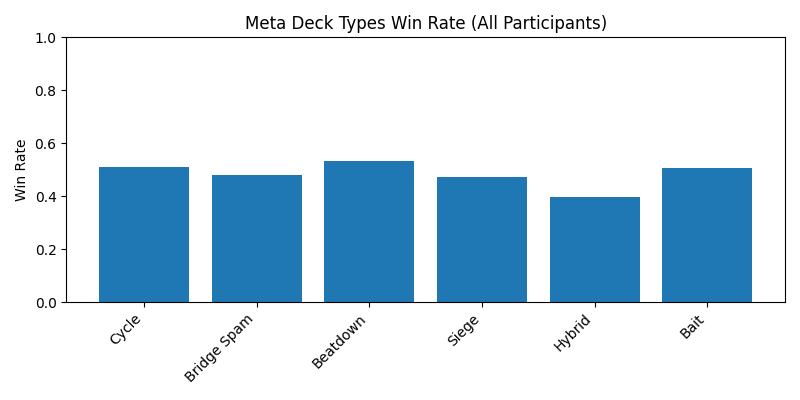


meta_deck_types.png


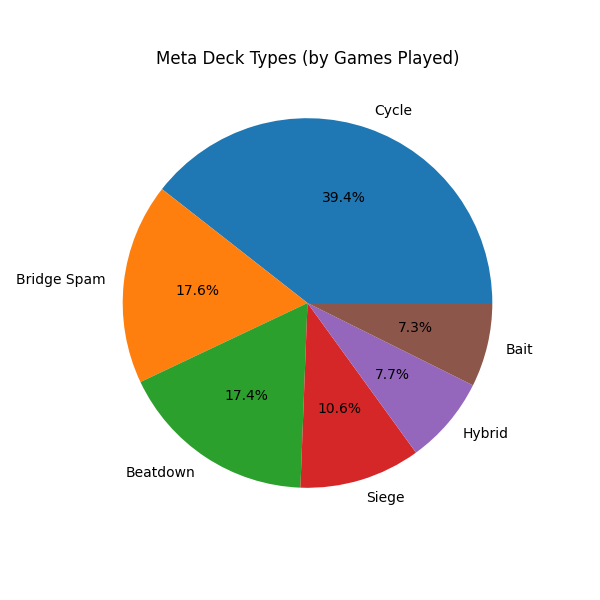


meta_matchups_bait.png


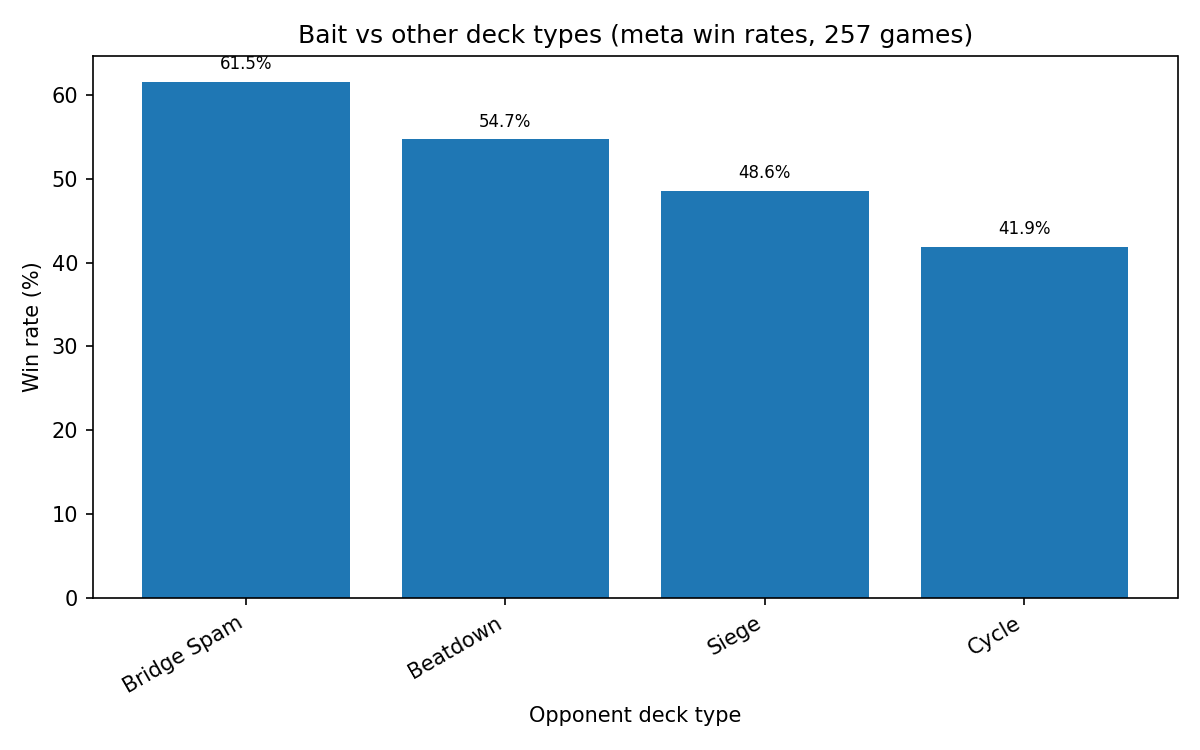


meta_matchups_beatdown.png


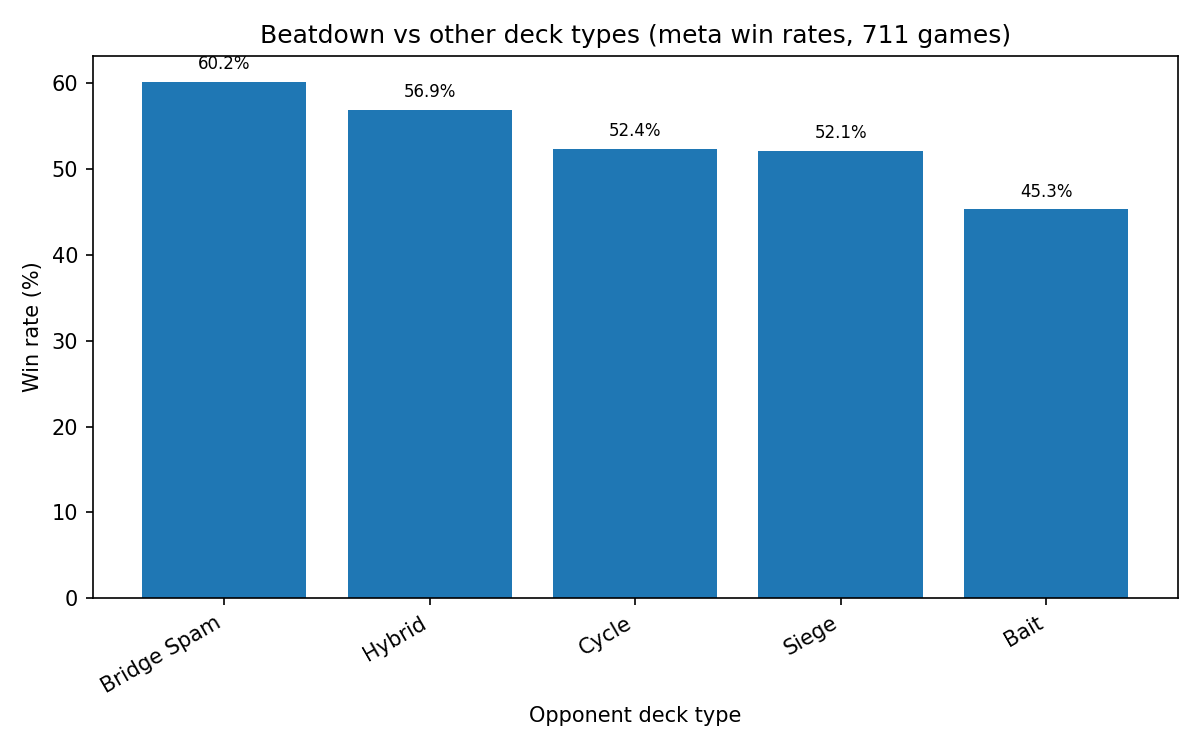


meta_matchups_bridge_spam.png


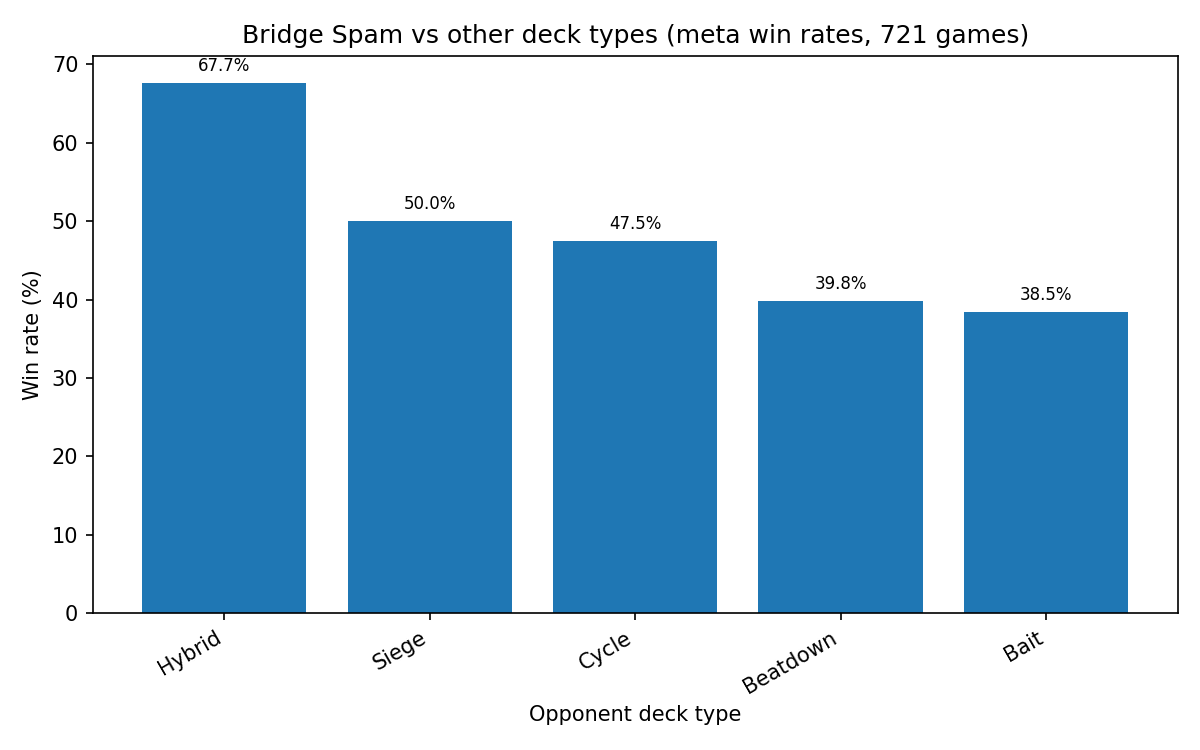


meta_matchups_cycle.png


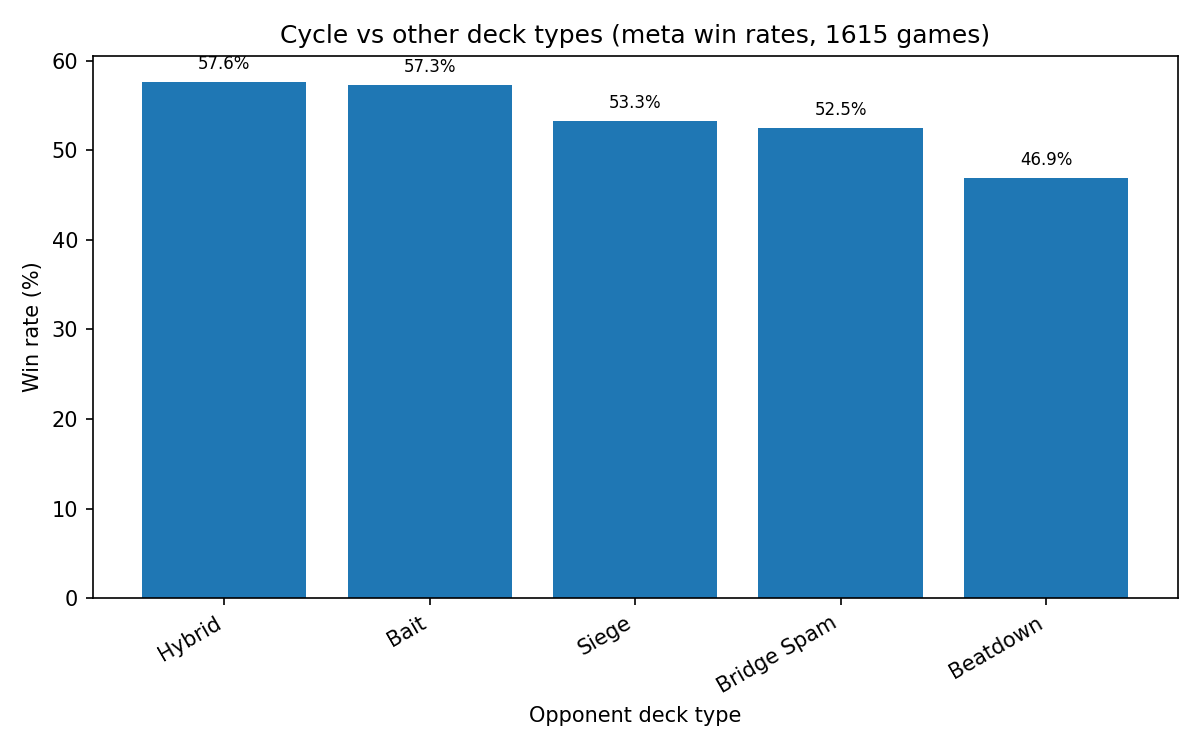


meta_matchups_hybrid.png


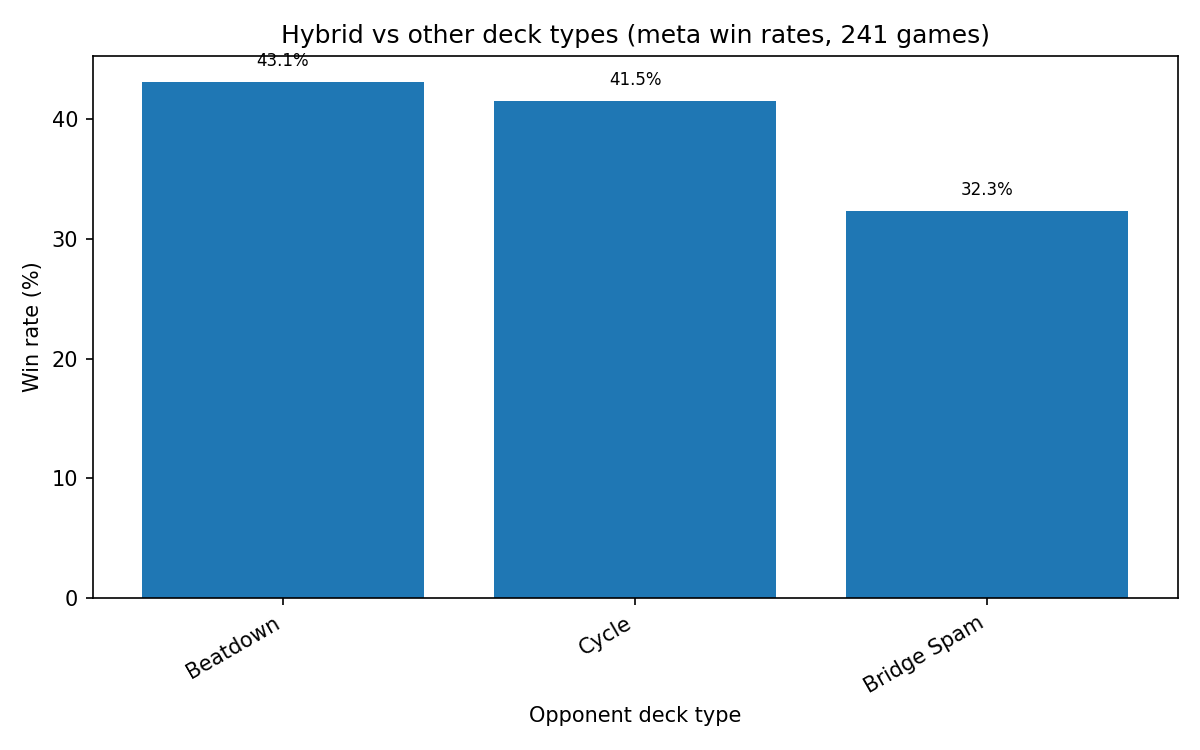


meta_matchups_siege.png


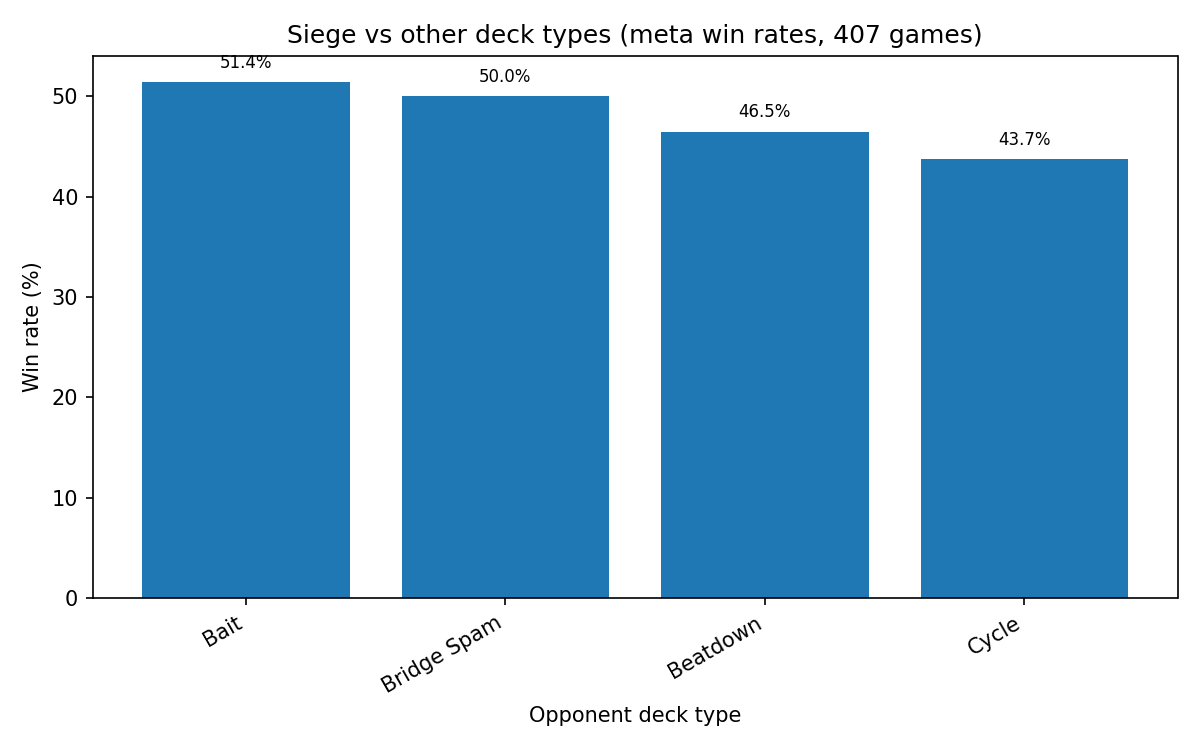


   Phase 1: User plots

user_best_cards.png


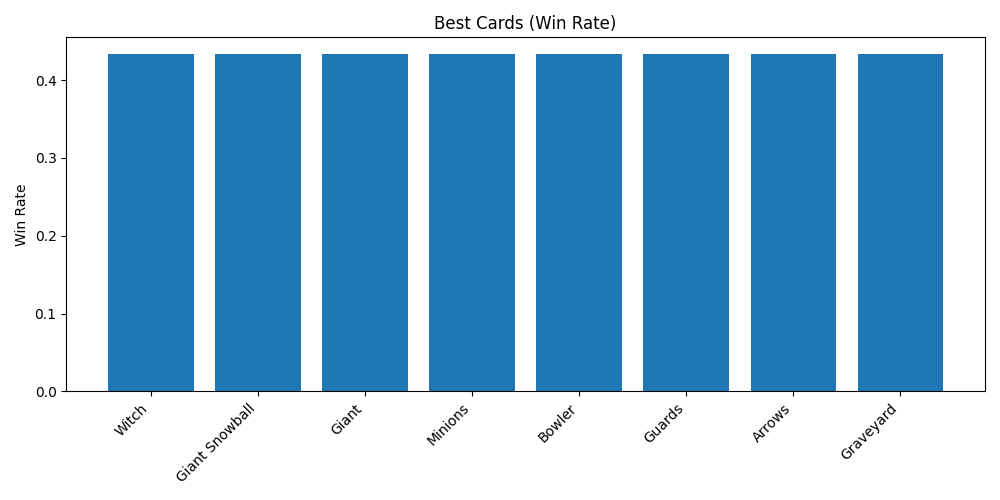


user_easy_opp_cards.png


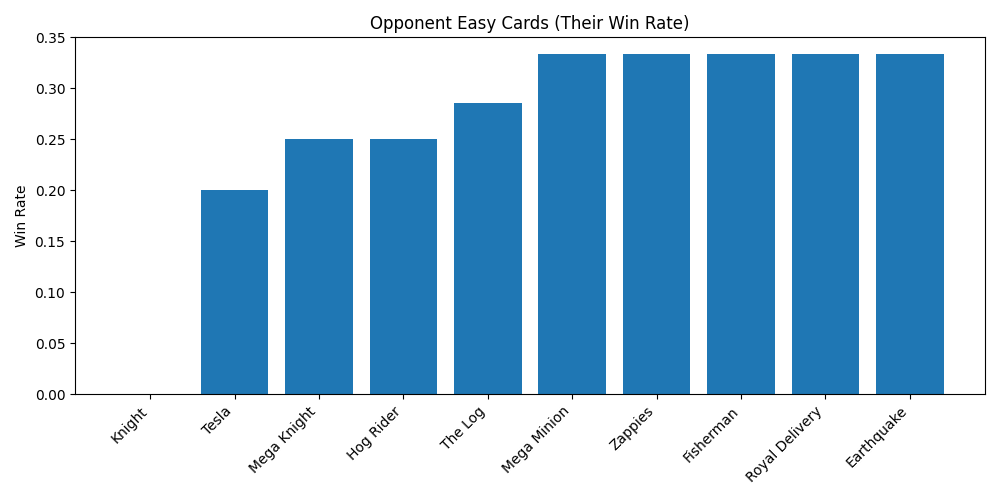


user_my_deck_types.png


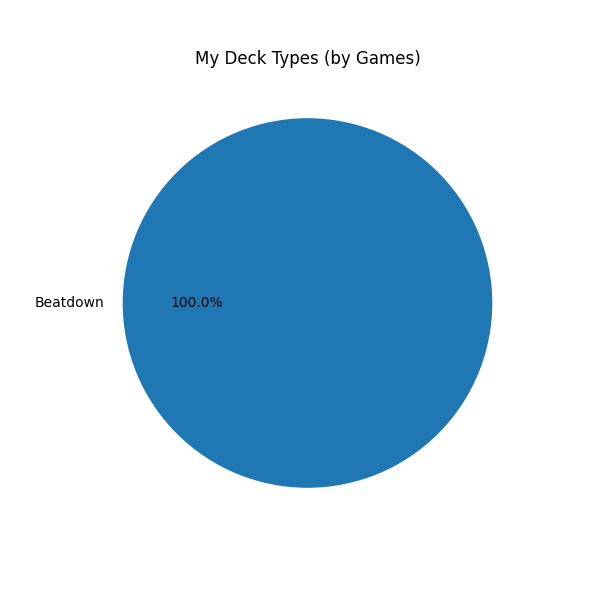


user_opp_deck_types_bar.png


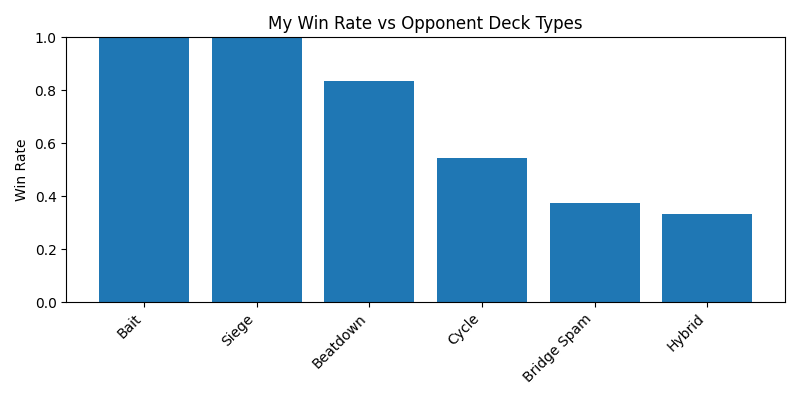


user_opp_deck_types.png


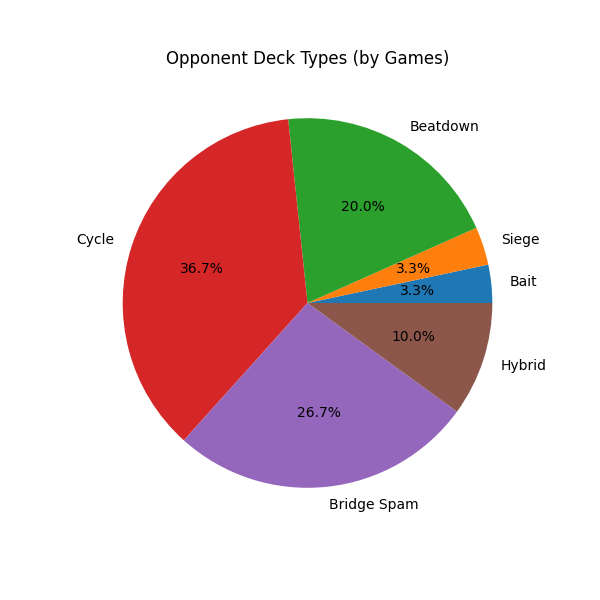


user_tough_opp_cards.png


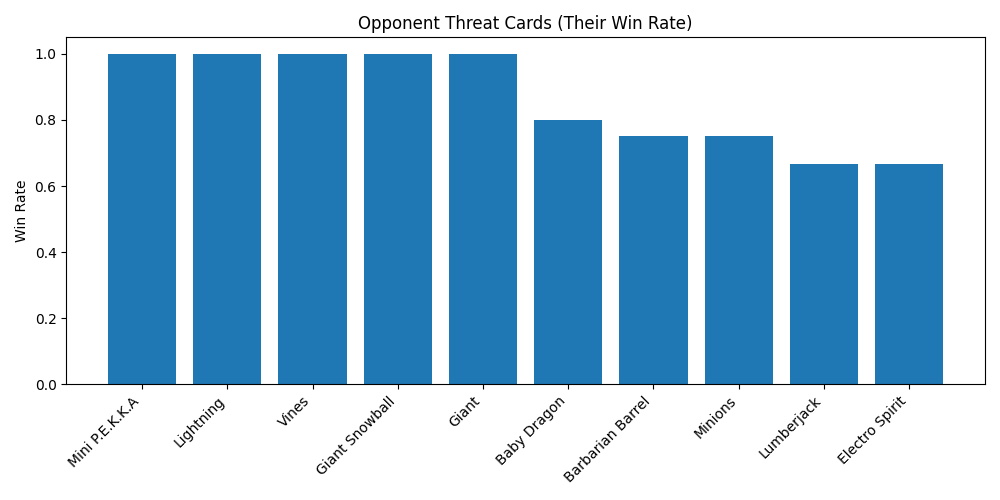


user_worst_cards.png


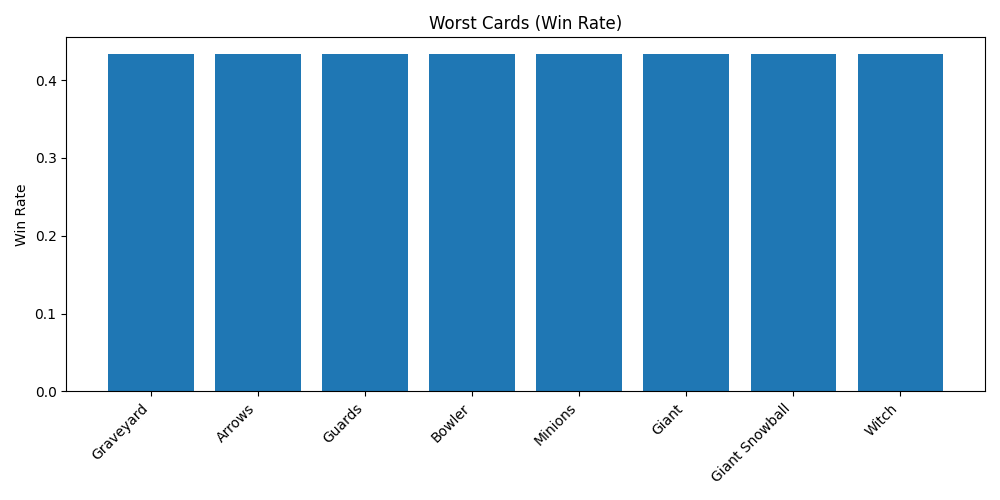

In [8]:
#Show created plots from Phase 0 and Phase 1
from pathlib import Path
from IPython.display import display, Image

PLOTS_DIR = Path("plots")

def show_named_plots(title: str, filenames: list[str], width: int = 650):
    """Display plots cleanly resized so the notebook looks good."""
    print(f"\n============================")
    print(f"   {title}")
    print(f"============================")

    if not PLOTS_DIR.exists():
        print(f"No '{PLOTS_DIR}' folder found.")
        return

    for fname in filenames:
        full_path = PLOTS_DIR / fname
        print(f"\n{fname}")
        if full_path.exists():
            display(Image(filename=str(full_path), width=width))
        else:
            print(f"[Missing] {full_path}")

# --- Phase 0: Meta plots ---
meta_plot_files = [
    "meta_deck_types_winrate.png",
    "meta_deck_types.png",
    "meta_matchups_bait.png",
    "meta_matchups_beatdown.png",
    "meta_matchups_bridge_spam.png",
    "meta_matchups_cycle.png",
    "meta_matchups_hybrid.png",
    "meta_matchups_siege.png",
]

show_named_plots("Phase 0: Meta plots", meta_plot_files)

# --- Phase 1: User plots ---
user_plot_files = [
    "user_best_cards.png",
    "user_easy_opp_cards.png",
    "user_my_deck_types.png",
    "user_opp_deck_types_bar.png",
    "user_opp_deck_types.png",
    "user_tough_opp_cards.png",
    "user_worst_cards.png",
]

show_named_plots("Phase 1: User plots", user_plot_files)


In [9]:
#Build Phase 2 Q&A graph

print("=== BUILDING PHASE 2 Q&A GRAPH ===")
qna_graph = build_qna_graph()
print("Q&A graph ready.")


=== BUILDING PHASE 2 Q&A GRAPH ===
Q&A graph ready.


In [ ]:
# Interactive Q&A loop (uses cached meta_state & user_state)

def ask_once(question: str):
    """Helper to run a single Q&A turn through the Phase 2 graph."""
    qna_input = {
        "user_tag": user_state.get("player_tag"),
        "question": question,
        "user_analytics": user_state.get("user_analytics", {}),
        "user_llm_tables": user_state.get("user_llm_tables", {}),
        "meta_analytics": meta_state.get("meta_analytics", {}),
        "meta_llm_tables": meta_state.get("meta_llm_tables", {}),
        "meta_table": meta_state.get("meta_table", []),
        "notes": [],
    }

    qna_state = qna_graph.invoke(qna_input)

    # Pull out values to display
    question_text = qna_state.get("question", "")
    category = qna_state.get("question_category", "unknown")
    context_text = qna_state.get("context_text", "").strip()
    answer = qna_state.get("answer", "(no answer)")
    notes = qna_state.get("notes", [])

    # USER-FRIENDLY CLEAN OUTPUT
    print(f"\n[Question]\n{question_text}")
    print(f"\n[Category]\n{category}")

    if context_text:
        print(f"\n[Context text]\n{context_text}")

    print("\n=== ANSWER ===\n")
    print(answer)

    # Keep only short internal trace
    print("\n[Last notes]")
    for line in notes[-5:]:
        print(" •", line)


# Simple REPL-style loop
while True:
    q = input("\nAsk a Clash question (or type 'quit' to exit):\n> ").strip()
    if q.lower() in {"quit", "exit"}:
        print("Goodbye!")
        break

    ask_once(q)



Ask a Clash question (or type 'quit' to exit):
>  what card do I have a hard time vs?



[Question]
what card do I have a hard time vs?

[Category]
card

[Context text]
Opponent card performance included.

=== ANSWER ===

Based on your matchup stats, the cards you have the most trouble with are those that show a low or mediocre win rate for you. Your win rate is weakest against Fireball (33%), Goblin Barrel (33%), Ice Spirit (40%), and Witch (40%). These cards likely cause challenges because they either counter your main win conditions or disrupt your plays effectively.

To improve, focus on adjusting your deck or playstyle to better handle these tough cards. For Fireball, try to spread your troops so they don’t get punished with one spell, and include cards resilient or resistant to spell damage. Against Goblin Barrel, having reliable small-area splash or fast-targeting counters like Log or Arrows can help. For Ice Spirit and Witch, prioritize quick cycle and clean-up troops that can efficiently neutralize their swarm or freeze effects.

Additionally, you seem to do well


Ask a Clash question (or type 'quit' to exit):
>  what is my winrate? how do I match up vs other deck type?



[Question]
what is my winrate? how do I match up vs other deck type?

[Category]
user

[Context text]
User overall stats are included (games, wins, losses, win rate).
User has matchup stats vs 6 archetypes showing win/loss rates by deck type.
Meta deck summary is available for 6 archetypes (games, win rate, meta share).
Meta matchup summary is available for 30 archetype pairs (attacker vs defender win rates).

=== ANSWER ===

Your overall win rate is about 43.3% across 30 games, with 13 wins and 17 losses. Against specific deck types using your Beatdown deck, your best matchups are versus Hybrid (66.7% win rate) and Bridge Spam (62.5% win rate). You have an almost even record against Cycle decks (45.5% win rate), but struggle significantly against other Beatdown decks (16.7% win rate), Bait (0%), and Siege decks (0%) in your sample.

Looking at the meta for Beatdown decks, they typically have a slightly above average win rate of about 53%, and they are favored against Bridge Spam and 

In [ ]:
what is my winrate? how do I match up vs other deck type?